In [31]:
import numpy as np
import matplotlib.pylab as plt
import sys
sys.path.insert(0, '../src_KD/kf')
from kf import KF
from trajectory import trajectory
np.set_printoptions(precision=2)

In [28]:
# %load_ext autoreload
%autoreload 2

# Cvičení: Sledování objektu ve 2D

Cílem tohoto cvičení je filtrace polohy objektu pohybujícího se na ploše, tj. ve 2D. Cílem je odhadovat stavový vektor sestávající se z polohy v osách $x_1$ a $x_2$ a rychlostech $v_{x_1}$ a $v_{x_2}$ v obou těchto osách. Stavový vektor má tedy podobu

$$
x_t =
\begin{bmatrix}
x_{1,t} \\ 
x_{2,t} \\ 
v_{x_1,t} \\ 
v_{x_2,t}
\end{bmatrix}
$$

Označme 

$$dt=1\mathrm{s}$$

časový krok. Víme, že pro polohu v první ose platí

$$
x_{1,t} = x_{1,t-1} + v_{x_1,t} dt + w_{x_1,t},
$$

a že analogicky platí totéž i pro polohu v ose druhé. Abychom se nemuseli zaobírat zrychlením, budeme uvažovat, že rychlost je stejná a její změny jsou způsobeny jen šumem,

$$
v_{x_1,t} = v_{x_1, t-1} + w_{vx_1, t}.
$$

Analogicky pro druhou složku rychlosti. Modelujeme tedy rychlost jako náhodnou procházku - uvažujeme ji konstantní a veškerý vývoj připisujeme jen aditivnímu šumu $w_{vx_1}$ a $w_{vx_2}$. Nezapomeňme, že tento šum má nulovou střední hodnotu, tedy i v rychlosti jsou ve střední hodnotě konstantní.

Takovému modelu se říká **constant velocity model** a používá se jako jednoduchý model pro sledování polohy cíle. Další možností je **constant acceleration model**, kde bychom uvažovali ještě zrychlení objektu. Modelovali bychom tedy navíc rychlosti $v_{x_1}$ a $v_{x_2}$ pomocí zrychlení o složkách $a_{x_1}$ a $a_{x_2}$. Pro ně samotné bychom potom použili model s náhodnou procházkou tak, jak to děláme v našem jednodušším modelu s rychlostmi.

### Model

K dispozici máme jen měření polohy v obou osách a to v časovém kroku $dt=1\mathrm{s}$. Jelikož tado měření polohy jsou zatížena šumem, způsobeným typicky GPS přijímačem, potřebujeme skutečnou polohu nějak "co nejlépe" rekonstruovat. A to online. Přesně tak, jak to dělá navigace v autě.

Potřebujeme sestavit stavový model

$$
\begin{aligned}
x_t &\sim \mathcal{N}(Ax_{t-1} + Bu_t, Q),\\
y_t &\sim \mathcal{N}(Hx_{t}, R).
\end{aligned}
$$

**Úkol 1: Sestavte stavový model a určete matice**

Kovarianční matice $Q$ a $R$ nám musí někdo dodat, níže jsou uvedeny. Obecně získání (naladění) kovariancí je jeden z náročnějších kroků.

\begin{align*}
    A &=
    \begin{bmatrix}
       1 & 0 & dt & 0 \\
       0 & 1 & 0 & dt \\
       0 & 0 & 1 &  0 \\
       0 & 0 & 0 &  1 
    \end{bmatrix},
    \quad
    &Q &= q\cdot
    \begin{bmatrix}
        \frac{dt^3}{3}    & 0                 & \frac{dt^{2}}{2}  & 0  \\
        0                 & \frac{dt^3}{3}    & 0                 & \frac{dt^{2}}{2} \\
        \frac{dt^{2}}{2}  & 0                 & dt                & 0 \\
        0                 & \frac{dt^{2}}{2}  & 0                 & dt
    \end{bmatrix}
    \notag \\
    H &=
    \begin{bmatrix}
        1 & 0 &0 & 0 \\
        0 & 1 &0 & 0
    \end{bmatrix}
    \quad
    &R &=
    r^{2}\cdot
    \begin{bmatrix}
        1 & 0 \\
        0 & 1
    \end{bmatrix}
\end{align*}
kde $dt = 1$, $q = .5$, $r=3$.

**Úkol 2: dodefinujte proměnné**

In [2]:
q = .5
dt = 1.
r = 3.
A = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1,  0],
              [0, 0, 0,  1]])
Q = q * np.array([[dt**3/3, 0      , dt**2/2, 0      ],
                  [0,       dt**3/3, 0,       dt**2/2],
                  [dt**2/2, 0,       dt,      0      ],
                  [0,       dt**2/2, 0,       dt     ]])
H = np.array([[1., 0, 0, 0],
              [0., 1, 0, 0]])
R = r**2 * np.eye(2)

**Úkol 3: doplňte za `code` den a měsíc svého svátku. V objektu `traj` budete mít trajektorii o 100 řádcích, v každém je poloha v obou osách. Vykreslete ji křížky.**

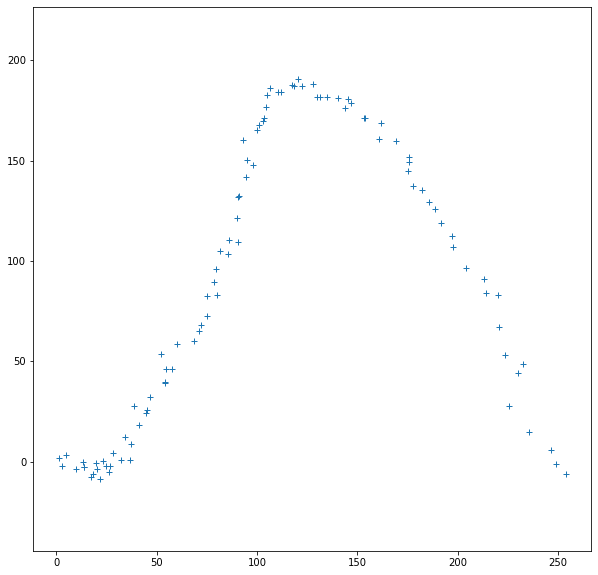

In [39]:
code = 810618
traj = trajectory(code)
plt.figure(figsize=(10, 10))
plt.plot(traj.Y[0,:], traj.Y[1,:], '+')
plt.axis('equal')
plt.show()

Pohledem do dat vidíme, jak se pohyb našeho sledovaného cíle vyvíjel. Samozřejmě chceme modelovat online, zde vidíme, jak to bylo po celé simulaci. Je jasné, že cíl neskákal přímo po křížcích, ale pohyboval se někde mezi nimi.

Kalmanův filtr je napsán jako třída KF. Tu si jednoduše pustíme, provede výpočty za vás. Předávají se jí jednotlivá měření polohy, tj. řádky v `traj.Y.T`

In [4]:
kf = KF(A=A, B=None, H=H, R=R, Q=Q)
for yt in traj.Y.T:
    kf.predict()
    kf.update(yt)
    kf.log()

log_x = np.array(kf.log_x).T      # Zde najdeme odhad

**Úkol 4: `log_x` má 4 řádky, v každém sloupci je jeden odhad stavu $x_{t}$. Vykreslete stejně jako výše naměřenou polohu a její filtrovaný odhad**

**`traj` má atribut X, tedy `traj.X`, což je matice o 4 řádcích, obsahující skutečné hodnoty polohy a rychlosti, které jsme se snažili Kalmanovým filtrem odhadnout. Doplňte je do obrázků černě.**

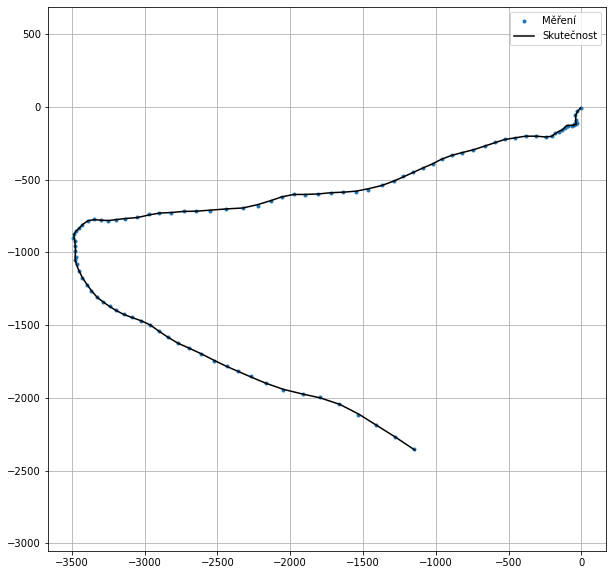

In [5]:
plt.figure(figsize=(10,10))
#plt.plot(X[0], X[1], '-', label='Trajectory')
plt.plot(traj.Y[0,:], traj.Y[1,:], '.', label='Měření')
#plt.plot(log_x[0,:], log_x[1,:], '-', color='red', label='Filtrovaný odhad')
plt.plot(traj.X[0,:], traj.X[1,:], 'k', label='Skutečnost')
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

Filtrovaný odhad polohy by měl poměrně slušně interpolovat data. Může se stát, že s rostoucím šumem odhady "ujedou", ale je potřeba na to nahlížet z kontextu měření - nejlepší, co má filtr k dispozici, je právě to měření.

**Úkol 5: V odhadech najdete i odhady rychlosti. Vykreslete je jako 2 subploty vedle sebe.**

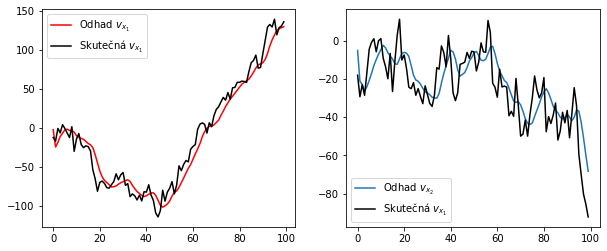

In [6]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(log_x[2,:], 'r', label=r'Odhad $v_{x_1}$')
plt.plot(traj.X[2,:], 'k', label=r'Skutečná $v_{x_1}$')
plt.legend()
plt.subplot(1,2,2)
plt.plot(log_x[3,:], label=r'Odhad $v_{x_2}$')
plt.plot(traj.X[3,:], 'k', label=r'Skutečná $v_{x_1}$')
plt.legend()
plt.show()

Jelikož jsme použili constant velocity model, kde vývoj rychlosti je připisován pouze náhodné procházce (centrované v 0) a je tedy nejtriviálnější možný, odhady nejsou úplně dobré. Lze v nich vysledovat dokonce jisté zpoždění. Pokud bychom na reálná data použili model se zrychlením, byly by odhady lepší.